# init

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
!which python

/home/lzhao/miniconda3/bin/./python


# setup

In [4]:
import os

In [5]:
# set up Spot username and password
os.environ['BOSDYN_CLIENT_USERNAME'] = 'user'
os.environ['BOSDYN_CLIENT_PASSWORD'] = 'bbbdddaaaiii'

In [6]:
%pwd

'/home/lzhao/repo/predicators/tmp'

In [7]:
%cd '/home/lzhao/repo/predicators/'

/home/lzhao/repo/predicators


# import for Spot

In [8]:
import logging
import math
import signal
import sys
import threading
import time

import bosdyn.client
import bosdyn.client
import bosdyn.client.util
import bosdyn.client.util
import cv2
import numpy as np
from PIL import Image
from bosdyn.api import geometry_pb2, image_pb2, world_object_pb2
from bosdyn.api.geometry_pb2 import Vec2
from bosdyn.api.spot import robot_command_pb2 as spot_command_pb2
from bosdyn.client import RpcError, create_standard_sdk, math_helpers
from bosdyn.client.frame_helpers import (BODY_FRAME_NAME, VISION_FRAME_NAME, get_a_tform_b, get_vision_tform_body)
from bosdyn.client.image import ImageClient, build_image_request
from bosdyn.client.lease import LeaseClient
from bosdyn.client.math_helpers import Quat
from bosdyn.client.power import PowerClient
from bosdyn.client.robot_command import RobotCommandBuilder, RobotCommandClient, blocking_stand
from bosdyn.client.robot_id import RobotIdClient, version_tuple
from bosdyn.client.robot_state import RobotStateClient
from bosdyn.client.world_object import WorldObjectClient, send_add_mutation_requests
from bosdyn.util import now_timestamp, seconds_to_duration

# from wasd import _setup_logging

# pylint: disable=no-member
LOGGER = logging.getLogger()

# (from fiducial_follow.py)
# Use this length to make sure we're commanding the head of the robot
# to a position instead of the center.
BODY_LENGTH = 1.1

# (from user_nogo_regions.py)
# Mobility command end time parameter.
_SECONDS_FULL = 10

# Dimensions of the box obstacle.  Frame for this obstacle is defined by the user when making the
# world object proto.
BOX_LEN_X = 0.2
BOX_LEN_Y_LONG = 10
BOX_LEN_Y_SHORT = 0.5

# steps

- get hand RGB-D image
- use SAM to segment object
- get medium depth of masked region in depth image
- compute XYZ position in desired frame

# get object mask from SAM

In [77]:
import argparse
import io
import requests
import time

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


def ask_sam(image, classes):
    buf = image_to_bytes(image)
    r = requests.post("http://localhost:5550/predict",
                      files={"file": buf},
                      data={"classes": ",".join(classes)}
                     )

    if r.status_code != 200:
        assert False, r.content

    with io.BytesIO(r.content) as f:
        arr = np.load(f, allow_pickle=True)
        boxes = arr['boxes']
        classes = arr['classes']
        masks = arr['masks']
        scores = arr['scores']

    return dict(boxes=boxes, classes=classes, masks=masks, scores=scores)


def image_to_bytes(img):

    buf = io.BytesIO()
    img.save(buf, format="PNG")
    buf.seek(0)
    return buf


def visualize_output(im, masks, input_boxes, classes, scores):
    plt.figure(figsize=(10, 10))
    plt.imshow(im)
    # im_rgb = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
    # im_rgb = im[..., ::-1]
    # plt.imshow(im_rgb)
    for mask in masks:
        show_mask(mask, plt.gca(), random_color=True)
    for box, class_name, score in zip(input_boxes, classes, scores):
        show_box(box, plt.gca())
        x, y = box[:2]
        plt.gca().text(x, y - 5, class_name + f': {score:.2f}', color='white', fontsize=12, fontweight='bold', bbox=dict(facecolor='green', edgecolor='green', alpha=0.5))
    plt.axis('off')
    plt.show()


def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))


def get_mask(image_in, classes):

    if isinstance(image_in, str):
        image = Image.open(image_in)
    elif isinstance(image_in, np.ndarray):
        image = Image.fromarray(image_in)
    else:
        raise NotImplementedError

    d = ask_sam(image, classes)
    visualize_output(image, d["masks"], d["boxes"], d["classes"], d["scores"])

    return d

In [78]:
image_path = './tmp/1.png'
classes = ['mug']

In [79]:
%pwd

'/home/lzhao/repo/predicators'

In [50]:
# res = get_mask(image_in=image_path, classes=classes)

In [51]:
# plt.imshow(res['masks'][0][0])

# get depth image from robot

In [52]:
import argparse
import sys

import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage

import bosdyn.client
import bosdyn.client.util
from bosdyn.api import image_pb2
from bosdyn.client.image import ImageClient, build_image_request, _depth_image_data_to_numpy, \
    _depth_image_get_valid_indices


ROTATION_ANGLE = {
    'back_fisheye_image': 0,
    'frontleft_fisheye_image': -78,
    'frontright_fisheye_image': -102,
    'left_fisheye_image': 0,
    'right_fisheye_image': 180
}

In [53]:
def pixel_format_type_strings():
    names = image_pb2.Image.PixelFormat.keys()
    return names[1:]


def pixel_format_string_to_enum(enum_string):
    return dict(image_pb2.Image.PixelFormat.items()).get(enum_string)


def depth_image_to_pointcloud_custom(image_response, masks=None, min_dist=0, max_dist=1000):
    """Converts a depth image into a point cloud using the camera intrinsics. The point
    cloud is represented as a numpy array of (x,y,z) values.  Requests can optionally filter
    the results based on the points distance to the image plane. A depth image is represented
    with an unsigned 16 bit integer and a scale factor to convert that distance to meters. In
    addition, values of zero and 2^16 (uint 16 maximum) are used to represent invalid indices.
    A (min_dist * depth_scale) value that casts to an integer value <=0 will be assigned a
    value of 1 (the minimum representational distance). Similarly, a (max_dist * depth_scale)
    value that casts to >= 2^16 will be assigned a value of 2^16 - 1 (the maximum
    representational distance).

    Args:
        image_response (image_pb2.ImageResponse): An ImageResponse containing a depth image.
        min_dist (double): All points in the returned point cloud will be greater than min_dist from the image plane [meters].
        max_dist (double): All points in the returned point cloud will be less than max_dist from the image plane [meters].

    Returns:
        A numpy stack of (x,y,z) values representing depth image as a point cloud expressed in the sensor frame.
    """

    if image_response.source.image_type != image_pb2.ImageSource.IMAGE_TYPE_DEPTH:
        raise ValueError('requires an image_type of IMAGE_TYPE_DEPTH.')

    if image_response.shot.image.pixel_format != image_pb2.Image.PIXEL_FORMAT_DEPTH_U16:
        raise ValueError(
            'IMAGE_TYPE_DEPTH with an unsupported format, requires PIXEL_FORMAT_DEPTH_U16.')

    if not image_response.source.HasField('pinhole'):
        raise ValueError('Requires a pinhole camera_model.')

    source_rows = image_response.source.rows
    source_cols = image_response.source.cols
    fx = image_response.source.pinhole.intrinsics.focal_length.x
    fy = image_response.source.pinhole.intrinsics.focal_length.y
    cx = image_response.source.pinhole.intrinsics.principal_point.x
    cy = image_response.source.pinhole.intrinsics.principal_point.y
    depth_scale = image_response.source.depth_scale

    # Convert the proto representation into a numpy array.
    depth_array = _depth_image_data_to_numpy(image_response)
    # print(depth_array.shape)

    # Determine which indices have valid data in the user requested range.
    valid_inds = _depth_image_get_valid_indices(depth_array, np.rint(min_dist * depth_scale),
                                                np.rint(max_dist * depth_scale))

    if masks is not None:
        valid_inds = valid_inds & masks

    # Compute the valid data.
    rows, cols = np.mgrid[0:source_rows, 0:source_cols]
    depth_array = depth_array[valid_inds]
    rows = rows[valid_inds]
    cols = cols[valid_inds]

    # Convert the valid distance data to (x,y,z) values expressed in the sensor frame.
    z = depth_array / depth_scale
    x = np.multiply(z, (cols - cx)) / fx
    y = np.multiply(z, (rows - cy)) / fy
    return np.vstack((x, y, z)).T, valid_inds


def process_image_response(image, options):
    num_bytes = 1  # Assume a default of 1 byte encodings.
    if image.shot.image.pixel_format == image_pb2.Image.PIXEL_FORMAT_DEPTH_U16:
        dtype = np.uint16
        extension = ".png"
    else:
        if image.shot.image.pixel_format == image_pb2.Image.PIXEL_FORMAT_RGB_U8:
            num_bytes = 3
        elif image.shot.image.pixel_format == image_pb2.Image.PIXEL_FORMAT_RGBA_U8:
            num_bytes = 4
        elif image.shot.image.pixel_format == image_pb2.Image.PIXEL_FORMAT_GREYSCALE_U8:
            num_bytes = 1
        elif image.shot.image.pixel_format == image_pb2.Image.PIXEL_FORMAT_GREYSCALE_U16:
            num_bytes = 2
        dtype = np.uint8
        extension = ".jpg"

    img = np.frombuffer(image.shot.image.data, dtype=dtype)
    if image.shot.image.format == image_pb2.Image.FORMAT_RAW:
        try:
            # Attempt to reshape array into a RGB rows X cols shape.
            img = img.reshape((image.shot.image.rows, image.shot.image.cols, num_bytes))
        except ValueError:
            # Unable to reshape the image data, trying a regular decode.
            img = cv2.imdecode(img, -1)
    else:
        img = cv2.imdecode(img, -1)

    if options.auto_rotate:
        img = ndimage.rotate(img, ROTATION_ANGLE[image.source.name])

    return img, extension

In [54]:
def get_hand_img(options):
    # Create robot object with an image client.
    sdk = bosdyn.client.create_standard_sdk('image_capture')
    robot = sdk.create_robot(options.hostname)
    bosdyn.client.util.authenticate(robot)
    robot.sync_with_directory()
    robot.time_sync.wait_for_sync()

    image_client = robot.ensure_client(options.image_service)

    # image_sources = ["frontleft_fisheye_image", "frontleft_depth_in_visual_frame"]
    image_sources = ["hand_color_image", "hand_depth_in_hand_color_frame"]

    pixel_format = pixel_format_string_to_enum(options.pixel_format)
    image_request = [
        build_image_request(source, pixel_format=pixel_format)
        for source in image_sources
    ]
    image_responses = image_client.get_image(image_request)

    color_img, _ = process_image_response(image_responses[0], options)
    print(color_img.shape)
    # plt.imshow(color_img)
    # plt.show()

    x, valid_inds = depth_image_to_pointcloud_custom(image_responses[1])

    d = np.sqrt(np.sum(np.square(x), axis=1))
    c = (color_img[:, :, ::-1][valid_inds] / 255.).astype(np.float32)
    # c = np.tile((color_img[valid_inds] / 255.).astype(np.float32)[:, None], (1, 3))

    x = x[d < 2.]
    c = c[d < 2.]

    print(x.shape, c.shape)

    import open3d as o3d
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(x)
    pcd.colors = o3d.utility.Vector3dVector(c)
    # FIXME error: [Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.
    # o3d.visualization.draw_geometries([pcd])

    res = {
        # 'rgb': process_image_response(image_responses[0], args1)[0],
        # 'depth': process_image_response(image_responses[1], args1)[0],
        # TODO fix BGR to RGB issue
        'rgb': process_image_response(image_responses[0], args1)[0][..., ::-1],
        'depth': process_image_response(image_responses[1], args1)[0][..., ::-1],
    }

    return res, image_responses

In [66]:
def get_body_img(options):
    # Create robot object with an image client.
    sdk = bosdyn.client.create_standard_sdk('image_capture')
    robot = sdk.create_robot(options.hostname)
    bosdyn.client.util.authenticate(robot)
    robot.sync_with_directory()
    robot.time_sync.wait_for_sync()

    image_client = robot.ensure_client(options.image_service)

    # image_sources = ["frontleft_fisheye_image", "frontleft_depth_in_visual_frame"]
    image_sources = ["hand_color_image", "hand_depth_in_hand_color_frame"]

    pixel_format = pixel_format_string_to_enum(options.pixel_format)
    image_request = [
        build_image_request(image_sources[0], pixel_format=image_pb2.Image.PIXEL_FORMAT_RGB_U8),
        build_image_request(image_sources[1], pixel_format=pixel_format)
        # for source in image_sources
    ]
    image_responses = image_client.get_image(image_request)

    color_img, _ = process_image_response(image_responses[0], options)
    print(color_img.shape)
    # plt.imshow(color_img)
    # plt.show()

    x, valid_inds = depth_image_to_pointcloud_custom(image_responses[1])

    d = np.sqrt(np.sum(np.square(x), axis=1))
    c = (color_img[:, :, ::-1][valid_inds] / 255.).astype(np.float32)
    # c = np.tile((color_img[valid_inds] / 255.).astype(np.float32)[:, None], (1, 3))

    x = x[d < 2.]
    c = c[d < 2.]

    print(x.shape, c.shape)

    import open3d as o3d
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(x)
    pcd.colors = o3d.utility.Vector3dVector(c)
    # FIXME error: [Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.
    # o3d.visualization.draw_geometries([pcd])

    res = {
        # 'rgb': process_image_response(image_responses[0], args1)[0],
        # 'depth': process_image_response(image_responses[1], args1)[0],
        # TODO fix BGR to RGB issue
        'rgb': process_image_response(image_responses[0], args1)[0][..., ::-1],
        'depth': process_image_response(image_responses[1], args1)[0][..., ::-1],
    }

    return res, image_responses

In [67]:
from dataclasses import dataclass

In [68]:
@dataclass
class TempArgs1:
    hostname: str = '10.17.30.30'  # TODO 6th floor
    # hostname: str = '10.17.30.21'
    # hostname: str = '10.17.30.29'  # kepler
    list: bool = True
    auto_rotate: bool = False  # unnecessary for hand
    image_service: str = ImageClient.default_service_name
    pixel_format: list = tuple(pixel_format_type_strings())

In [69]:
args1 = TempArgs1()

In [70]:
args1

TempArgs1(hostname='10.17.30.30', list=True, auto_rotate=False, image_service='image', pixel_format=('PIXEL_FORMAT_GREYSCALE_U8', 'PIXEL_FORMAT_RGB_U8', 'PIXEL_FORMAT_RGBA_U8', 'PIXEL_FORMAT_DEPTH_U16', 'PIXEL_FORMAT_GREYSCALE_U16'))

In [143]:
res1, image_responses1 = get_hand_img(options=args1)
# TODO test body
# res1, image_responses1 = get_body_img(options=args1)

UnableToConnectToRobotError: UnableToConnectToRobotError: The robot may be offline or otherwise unreachable.

### try to process images

In [ ]:
plt.imshow(res1['rgb'])
# plt.imshow(res1['rgb'][..., ::-1])  # TODO fixed BGR issue above

In [ ]:
plt.imshow(res1['depth'])

### rotate images

In [ ]:
# rotated_rgb = ndimage.rotate(res1['rgb'], ROTATION_ANGLE['frontleft_fisheye_image'])
# rotated_depth = ndimage.rotate(res1['depth'], ROTATION_ANGLE['frontleft_fisheye_image'])

# connect SAM with RGB

In [ ]:
# res2 = get_mask(image_in=res1['rgb'], classes=['hammer'])
# res2 = get_mask(image_in=res1['rgb'], classes=['hex key'])
# res2 = get_mask(image_in=res1['rgb'], classes=['yellow hex key', 'yellow hammer', 'red hammer'])
# res2 = get_mask(image_in=res1['rgb'], classes=['hammer', 'socket', 'shelf'])
# res2 = get_mask(image_in=res1['rgb'], classes=['desk', 'screwer', 'hex key', 'tool', 'hammer'])
# res2 = get_mask(image_in=res1['rgb'], classes=['fiducial paper box', 'fiducial', 'qr code box'])
# res2 = get_mask(image_in=res1['rgb'], classes=['qr code box'])
# res2 = get_mask(image_in=res1['rgb'], classes=['qr code cube'])
# res2 = get_mask(image_in=res1['rgb'], classes=['qr code'])
# res2 = get_mask(image_in=res1['rgb'], classes=['hex key', 'yellow tool', 'scissor', 'screwer'])
# res2 = get_mask(image_in=res1['rgb'], classes=['yellow brush', 'yellow-black brush'])
# res2 = get_mask(image_in=res1['rgb'], classes=['yellow brush'])
# res2 = get_mask(image_in=res1['rgb'], classes=['blue tool'])
# res2 = get_mask(image_in=res1['rgb'], classes=['yellow scissor'])
# res2 = get_mask(image_in=res1['rgb'], classes=['red screw driver'])
# res2 = get_mask(image_in=res1['rgb'], classes=['green-black screw driver'])
# res2 = get_mask(image_in=res1['rgb'], classes=['screw driver', 'measuring tape', 'red-black hammer', 'mallet'])
# res2 = get_mask(image_in=res1['rgb'], classes=['measuring tape', 'mallet', 'hammer'])
# res2 = get_mask(image_in=res1['rgb'], classes=['screw driver', 'tape'])
# res2 = get_mask(image_in=res1['rgb'], classes=['measuring tape', 'hammer', 'bursh', 'screw driver', 'tape'])
# res2 = get_mask(image_in=res1['rgb'], classes=['measuring tape', 'hammer', 'bursh'])
res2 = get_mask(image_in=res1['rgb'], classes=['bursh'])

In [ ]:
# res2 = get_mask(image_in=rotated_rgb, classes=['brush'])
# res2 = get_mask(image_in=rotated_rgb, classes=['screw driver'])
# res2 = get_mask(image_in=rotated_rgb, classes=['red screw driver'])

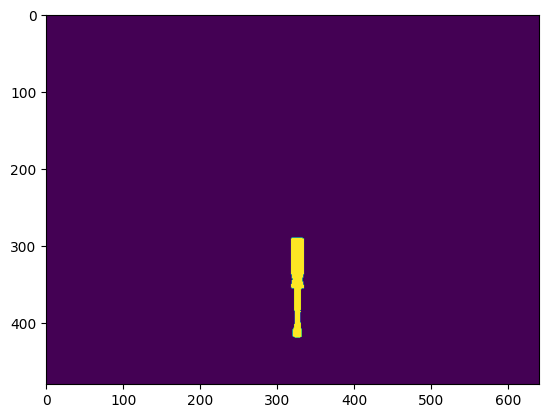

In [110]:
plt.imshow(res2['masks'][0][0])

In [29]:
res2['masks'].shape

(1, 1, 726, 603)

In [30]:
res2['boxes'].shape

(1, 4)

# get maksed depth estimation

In [31]:
res1['depth'][res2['masks'][0][0] & (res1['depth'] > 2)[:, :, 0]]

ValueError: operands could not be broadcast together with shapes (726,603) (480,640) 

In [ ]:
np.median(res1['depth'][res2['masks'][0][0]])

In [ ]:
# plt.hist(res1['depth'][res2['masks'][0][0]])
plt.hist(res1['depth'][res2['masks'][0][0] & (res1['depth'] > 2)[:, :, 0]])

In [ ]:
np.median(res1['depth'][res2['masks'][0][0] & (res1['depth'] > 2)[:, :, 0]])

In [ ]:
median_depth = res1['depth'][res2['masks'][0][0] & (res1['depth'] > 2)[:, :, 0]]

# get center of object

In [ ]:
res2['boxes'][0]

In [ ]:
x1, y1, x2, y2 = res2['boxes'][0]

In [ ]:
x_c = (x1 + x2) / 2
y_c = (y1 + y2) / 2

In [ ]:
x_c, y_c

In [ ]:
plt.imshow(res2['masks'][0][0])
plt.scatter(x_c, y_c, marker='*', color='red', zorder=3)

# get point cloud

In [ ]:
image_responses1

In [ ]:
depth_image_to_pointcloud_custom(image_responses1[1])

### try to visualize point cloud

In [ ]:
x, valid_inds = depth_image_to_pointcloud_custom(image_responses1[1])

d = np.sqrt(np.sum(np.square(x), axis=1))
c = (res1['rgb'][:, :, ::-1][valid_inds] / 255.).astype(np.float32)
# c = np.tile((color_img[valid_inds] / 255.).astype(np.float32)[:, None], (1, 3))

x = x[d < 2.]
c = c[d < 2.]

print(x.shape, c.shape)

In [ ]:
# import open3d as o3d
# import open3d.visualization
#
# pcd = o3d.geometry.PointCloud()
# pcd.points = o3d.utility.Vector3dVector(x)
# pcd.colors = o3d.utility.Vector3dVector(c)
# # FIXME error: [Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.
# o3d.visualization.draw_geometries([pcd])

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[:, 0], x[:, 1], x[:, 2], c='blue', marker='.')

In [ ]:
res2['masks'].shape

# convert into correct reference frame

In [ ]:
def get_xyz_from_depth(image_response, depth_value, point_x, point_y, min_dist=0, max_dist=1000):
    """
    This is a function based on `depth_image_to_pointcloud`
    """
    if image_response.source.image_type != image_pb2.ImageSource.IMAGE_TYPE_DEPTH:
        raise ValueError('requires an image_type of IMAGE_TYPE_DEPTH.')

    if image_response.shot.image.pixel_format != image_pb2.Image.PIXEL_FORMAT_DEPTH_U16:
        raise ValueError(
            'IMAGE_TYPE_DEPTH with an unsupported format, requires PIXEL_FORMAT_DEPTH_U16.')

    if not image_response.source.HasField('pinhole'):
        raise ValueError('Requires a pinhole camera_model.')

    fx = image_response.source.pinhole.intrinsics.focal_length.x
    fy = image_response.source.pinhole.intrinsics.focal_length.y
    cx = image_response.source.pinhole.intrinsics.principal_point.x
    cy = image_response.source.pinhole.intrinsics.principal_point.y
    depth_scale = image_response.source.depth_scale

    # Convert the valid distance data to (x,y,z) values expressed in the sensor frame.
    z = depth_value / depth_scale
    x = np.multiply(z, (point_x - cx)) / fx
    y = np.multiply(z, (point_y - cy)) / fy
    # return np.vstack((x, y, z)).T, valid_inds
    return x, y, z

In [ ]:
get_xyz_from_depth(
    image_responses1[1],
    depth_value=np.median(res1['depth'][res2['masks'][0][0]]),
    point_x=x_c,
    point_y=y_c
)

In [ ]:
x0, y0, z0 = get_xyz_from_depth(
    image_responses1[1],
    # depth_value=np.median(res1['depth'][res2['masks'][0][0]]),
    depth_value=np.median(res1['depth'][res2['masks'][0][0] & (res1['depth'] > 2)[:, :, 0]]),
    point_x=x_c,
    point_y=y_c
)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[:, 0], x[:, 1], x[:, 2], c='blue', marker='.')

ax.scatter(xs=x0, ys=y0, zs=z0, c='red', marker='*')
# plt.plot()

# merge into functions

- get hand RGB-D image responses - done
- use SAM to get masks -- done
-

In [ ]:
def get_object_locations_with_sam(
        args,
        classes,
        in_res_image=None, in_res_image_responses=None,
        plot=True
):

    if in_res_image is None or in_res_image_responses is None:
        # res_image, res_image_responses = get_hand_img(options=args)
        # TODO use body camera
        res_image, res_image_responses = get_body_img(options=args)
        # return of res_image: 'rgb', 'depth'
        # return of res_image_responses: RGB and depth image responses with camera info
    else:
        res_image = in_res_image
        res_image_responses = in_res_image_responses

    # FIXME debug
    if plot:
        plt.imshow(res_image['rgb'])
        plt.show()

    rotated_rgb = ndimage.rotate(res_image['rgb'], ROTATION_ANGLE['frontleft_fisheye_image'])
    rotated_depth = ndimage.rotate(res_image['depth'], ROTATION_ANGLE['frontleft_fisheye_image'])

    # res_segment = get_mask(image_in=res_image['rgb'], classes=classes)
    res_segment = get_mask(image_in=rotated_rgb, classes=classes)
    # return: 'masks', 'boxes', 'classes'

    obj_num = len(res_segment['masks'])

    # Detect multiple objects with their masks
    for i in range(obj_num):
        # Compute median value of depth
        # depth_median = np.median(
        #     res_image['depth'][res_segment['masks'][i][0] & (res_image['depth'] > 2)[:, :, 0]]
        # )
        depth_median = np.median(
            rotated_depth[res_segment['masks'][i][0] & (rotated_depth > 2)[:, :, 0]]
        )

        # Compute geometric center of object bounding box
        x1, y1, x2, y2 = res_segment['boxes'][i]
        x_c = (x1 + x2) / 2
        y_c = (y1 + y2) / 2

        # FIXME
        # Get the inverse rotation angle
        inverse_rotation_angle = -ROTATION_ANGLE['frontleft_fisheye_image']
        # Create a transformation matrix for the inverse rotation
        transform_matrix = np.array(
            [[np.cos(inverse_rotation_angle), -np.sin(inverse_rotation_angle)],
             [np.sin(inverse_rotation_angle), np.cos(inverse_rotation_angle)]])
        # Subtract the center of the image from the pixel location to translate the rotation to the origin
        # TODO x - 0 and y - 1?
        center = np.array([rotated_rgb.shape[0] / 2., rotated_rgb.shape[1] / 2.])
        pixel_centered = np.array([x_c, y_c]) - center
        # Apply the rotation
        rotated_pixel_centered = np.dot(transform_matrix, pixel_centered)
        # Add the center of the image back to the pixel location to translate the rotation back from the origin
        rotated_pixel = rotated_pixel_centered + center
        # Now rotated_pixel is the location of the pixel after the inverse rotation
        x_c_rotated = rotated_pixel[0]
        y_c_rotated = rotated_pixel[1]

        # Plot center and segmentation mask
        if plot:
            plt.imshow(res_segment['masks'][i][0])
            plt.scatter(x_c, y_c, marker='*', color='red', zorder=3)
            plt.show()

        # Get XYZ of the point at center of bounding box and median depth value
        x0, y0, z0 = get_xyz_from_depth(
            res_image_responses[1],
            depth_value=depth_median,
            # point_x=x_c,
            # point_y=y_c
            point_x=x_c_rotated,
            point_y=y_c_rotated
        )

        print((x0, y0, z0))

        # TODO no fix now
        # x, valid_inds = depth_image_to_pointcloud_custom(
        #     res_image_responses[1],
        #     masks=res_segment['masks'][i][0],
        # )

        # if plot:
        #     fig = plt.figure()
        #     ax = fig.add_subplot(111, projection='3d')
        #     ax.scatter(x[:, 0], x[:, 1], x[:, 2], c='blue', marker='.')
        #
        #     ax.scatter(xs=x0, ys=y0, zs=z0, c='red', marker='*')
        #     plt.show()

    return

In [ ]:
get_object_locations_with_sam(
    args1,
    # classes=['scissor'],
    classes=['brush'],
    # in_res_image=res1, in_res_image_responses=image_responses1
)